Forested Protected Lands
===

This notebook uses the natural land area and total geometry area obtained from ModelMyWatershed in `Retrieve_Natural_Land.ipynb` to ultimately determine the percent of natural protected land within each focus area. 

# Setup

## Imports

In [1]:
# Import packages
from pathlib import Path
import pandas as pd
import numpy as np
import geopandas as gpd
import json
from shapely.validation import make_valid
import imp
import warnings

# Plotting packages
import matplotlib
import matplotlib.pyplot as plt
from  matplotlib.colors import LogNorm
import contextily as ctx
import colorcet as cc
from colorcet.plotting import swatch, swatches, sine_combs
import holoviews as hv

C:\Users\clulay\AppData\Local\Temp\ipykernel_23160\1587244398.py:8: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  import imp


In [2]:
# Look at swatches
# hv.extension("matplotlib")
#swatches()

# CET_D3, CET_CBTL4, diverging_gkr_60_10_c40

In [3]:
# If kernel has not been restarted, restart before running this cell
# Confirm that this repo is in your Python Path
!conda-develop "/Users/clulay/OneDrive - LimnoTech/Documents/GitHub/pollution-assessment/src"

path exists, skipping C:\Users\clulay\OneDrive - LimnoTech\Documents\GitHub\pollution-assessment\src
completed operation for: C:\Users\clulay\OneDrive - LimnoTech\Documents\GitHub\pollution-assessment\src


In [4]:
# Import PA custom functions
import pollution_assessment as pa
from pollution_assessment import plot, plot_protected_land

In [5]:
# Supress future warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

## File paths

In [6]:
# Find your current working directory, which should be folder for this notebook.
Path.cwd()

WindowsPath('C:/Users/clulay/OneDrive - LimnoTech/Documents/GitHub/pollution-assessment/stage2')

In [7]:
# Set your project directory to your local folder for your clone of this repository
project_path = Path.cwd().parent
project_path

WindowsPath('C:/Users/clulay/OneDrive - LimnoTech/Documents/GitHub/pollution-assessment')

In [8]:
# Path to WeConservePA protected lands shapefile
wcpa_path = project_path / Path('stage2/Protected_Lands/WCPA_exclude_DRWI.parquet')
wcpa_path.exists()

True

## Private file paths
- Download from https://drive.google.com/drive/folders/1HKlnA3lC2xvKBQ1bg1J08gsEB3N9rp2V
- Save in `stage2/private` folder

In [9]:
# Path to FieldDoc protected lands export file
fielddoc_path = project_path / Path('stage2/private/protection_bmps_from_FieldDoc.parquet')
fielddoc_path.exists()

True

# Load data

## WeConservePA protected lands

### Spatial 

In [10]:
# Import weconservePA protected lands
wcpa_gdf = gpd.read_parquet(wcpa_path)

In [11]:
# Add data source tag
wcpa_gdf['data_source'] = 'weconservePA_2022'

### Natural lands

In [12]:
# Load all natural land parquet files
wcpa1_natural_df = pd.read_parquet(project_path / Path('stage2/Protected_Lands/natural_lands/wcpa1_naturalland.parquet')) 
wcpa2_natural_df = pd.read_parquet(project_path / Path('stage2/Protected_Lands/natural_lands/wcpa2_naturalland.parquet'))  
wcpa3_natural_df = pd.read_parquet(project_path / Path('stage2/Protected_Lands/natural_lands/wcpa3_naturalland.parquet'))  
wcpa4_natural_df = pd.read_parquet(project_path / Path('stage2/Protected_Lands/natural_lands/wcpa4_naturalland.parquet'))  
wcpa5_natural_df = pd.read_parquet(project_path / Path('stage2/Protected_Lands/natural_lands/wcpa5_naturalland.parquet'))  

# Concatenate all WCPA natural land files
wcpa_natural_df = wcpa1_natural_df.append(wcpa2_natural_df)
wcpa_natural_df = wcpa_natural_df.append(wcpa3_natural_df)
wcpa_natural_df = wcpa_natural_df.append(wcpa4_natural_df)
wcpa_natural_df = wcpa_natural_df.append(wcpa5_natural_df)

## FieldDoc protected lands

### Spatial

In [13]:
# Import FieldDoc protected lands 
fielddoc_gdf = gpd.read_parquet(fielddoc_path)

# Add a column to fielddoc_gdf with data source
fielddoc_gdf['data_source'] = 'fielddoc_2022-08-11'

In [14]:
#Identify any invalid geometries
fielddoc_gdf_invalid = fielddoc_gdf[fielddoc_gdf.is_valid == False]
invalid_ind = fielddoc_gdf_invalid.index.to_list()
fielddoc_gdf_invalid

,practice_name,practice_id,program_name,program_id,organization,description,practice_type,created_at,modified_at,tot_pwr,head_pwr,nat_land,ara_pwr,wet_pwr,dev_land,ag_land,str_bank,geometry,data_source
51,Cherry Valley,51721,Delaware River Watershed Protection Fund - For...,5,Academy of Natural Sciences of Drexel University,None,Conservation easement,2021-07-07T20:52:08.441117Z,2021-07-19T13:45:32.427800Z,1212.41,1212.41,1207.83,44.39,4.10,7.34,0.00,0.44,"POLYGON ((-75.28705 40.85999, -75.28807 40.861...",fielddoc_2022-08-11
65,Lubbers Run Greenway Phase II,51769,Delaware River Watershed Protection Fund - For...,5,The Commons,None,Conservation easement,2021-07-12T15:50:59.231051Z,2021-07-12T15:52:54.715969Z,2206.46,2199.19,2389.41,632.76,233.84,44.03,17.12,9.92,"MULTIPOLYGON (((-74.69218 40.95727, -74.69216 ...",fielddoc_2022-08-11


In [15]:
# Fix invalid geometries
for i in invalid_ind:
    geom = fielddoc_gdf.loc[i]['geometry']
    valid = make_valid(geom)
    fielddoc_gdf.at[i,'geometry'] = valid

### Natural lands

In [16]:
# Load natural land parquet file
fd_natural_df = pd.read_parquet(project_path / Path('stage2/Protected_Lands/natural_lands/fd_naturalland.parquet'))  

## DRWI geographies

### Spatial

In [17]:
# Load cluster and focus area geometries
cluster_gdf = gpd.read_parquet(project_path / Path('stage1/data/cluster_df.parquet'))  
focusarea_gdf = gpd.read_parquet(project_path / Path('stage1/data/fa_phase2_df.parquet'))

# Add a "-" to the KC Aquifer name for consistency
focusarea_gdf.cluster = focusarea_gdf.cluster.replace('Kirkwood Cohansey Aquifer', 'Kirkwood - Cohansey Aquifer') 
focusarea_gdf.set_index('name', inplace=True)

### Natural lands

In [18]:
# Load cluster natural land parquet file
cl_natural_df = pd.read_parquet(project_path / Path('stage2/Protected_Lands/natural_lands/cluster_naturalland.parquet'))  
cl_natural_df = cl_natural_df.drop('ans_area_ac', axis=1)

# Add a "-" to the KC Aquifer name for consistency
cl_natural_df['name'] = cl_natural_df['name'].replace('Kirkwood Cohansey Aquifer', 'Kirkwood - Cohansey Aquifer')

# Reset index to join on index
cl_natural_df.set_index('name', inplace=True)

In [19]:
# Load focus area natural land parquet file
fa_natural_df = pd.read_parquet(project_path / Path('stage2/Protected_Lands/natural_lands/focusarea_naturalland.parquet'))  
fa_natural_df = fa_natural_df.drop('ans_area_ac', axis=1)

# Reset index to join on index
fa_natural_df.set_index('name', inplace=True)

## HUC 8 & 12

### Spatial

In [20]:
huc12_gdf = gpd.read_parquet(project_path / Path('stage2/data_output/huc12_0204.parquet'))
huc08_gdf = gpd.read_parquet(project_path / Path('stage2/data_output/huc08_0204.parquet'))

In [21]:
# list of hucs in DRB
huc12_in_drb_df = pd.read_csv(project_path / Path('stage1/mmw_huc12_loads/mmw_drbloads.csv'))
huc08_in_drb_df = pd.read_csv(project_path / Path('stage1/data/comids0204_in_drb.csv'))

In [22]:
hucs12_in_drb_list = huc12_in_drb_df['huc12'].to_list()

In [23]:
hucs12_in_drb_list = [str(i).zfill(12) for i in hucs12_in_drb_list]

In [24]:
huc08_in_drb_df = huc08_in_drb_df[huc08_in_drb_df['in_drb'] == 't']

In [25]:
hucs08_in_drb_list = huc08_in_drb_df['huc08'].to_list()
hucs08_in_drb_list = [str(i).zfill(8) for i in hucs08_in_drb_list]

### Natural lands

In [26]:
huc12_natural_df = pd.read_parquet(project_path / Path('stage2/Protected_Lands/natural_lands/huc12_naturallands.parquet')) 

### Protected lands

In [27]:
huc12_protec_gdf = pd.read_parquet(project_path / Path('stage2/Protected_Lands/huc12_protection.parquet'))

# Join natural lands to original gdfs

Natural lands gdfs do not contain spatial information, so they must b ejoined to the original gdfs which do contain this information.

## Clusters

In [28]:
clusterjoin_gdf = cluster_gdf.join(cl_natural_df, lsuffix='_cluster_gdf')

## Focus areas

In [29]:
fajoin_gdf = focusarea_gdf.join(fa_natural_df, lsuffix='_focusarea_gdf')

## FieldDoc

In [30]:
fielddocjoin_gdf = fielddoc_gdf.merge(fd_natural_df, left_on='practice_id', right_on='name', how='left')

In [31]:
#Identify any invalid geometries
fielddocjoin_gdf_invalid = fielddocjoin_gdf[fielddocjoin_gdf.is_valid == False]
invalid_ind = fielddocjoin_gdf_invalid.index.to_list()

# Fix invalid geometries
for i in invalid_ind:
    geom = fielddocjoin_gdf.loc[i]['geometry']
    valid = make_valid(geom)
    fielddocjoin_gdf.at[i,'geometry'] = valid

## WeConservePA

In [32]:
wcpajoin_gdf = wcpa_gdf.merge(wcpa_natural_df, left_on='OBJECTID', right_on='name', how='left')

In [33]:
#Identify any invalid geometries
wcpa_gdf_invalid = wcpajoin_gdf[wcpajoin_gdf.is_valid == False]
invalid_ind = wcpa_gdf_invalid.index.to_list()

# Fix invalid geometries
for i in invalid_ind:
    geom = wcpajoin_gdf.loc[i]['geometry']
    valid = make_valid(geom)
    wcpajoin_gdf.at[i,'geometry'] = valid

## HUCs

In [34]:
huc12join_gdf = huc12_gdf.merge(huc12_natural_df, left_on='huc12', right_on='name', how='left')

In [35]:
huc12_geom = huc12_gdf[['huc12','geometry']]

In [36]:
huc12_protec_gdf.drop('geometry',axis=1,inplace=True)

In [37]:
huc12_protec_gdf = huc12_gdf.merge(huc12_protec_gdf, left_on='huc12', right_index=True, how='right')

# Set CRS

In [38]:
# FD has no projection. Assign projection first, then convert to equal-area
fielddocjoin_gdf = fielddocjoin_gdf.set_crs(epsg=4326, inplace=True,allow_override=True)
fielddoc_gdf = fielddoc_gdf.set_crs(epsg=4326, inplace=True,allow_override=True)

In [39]:
# Set to equal area crs for proper computation of areas
ea_crs = 'ESRI:102003'

gdf_list = [fielddocjoin_gdf, clusterjoin_gdf, fajoin_gdf,
            wcpajoin_gdf, huc12join_gdf, huc08_gdf,
            huc12_gdf, fielddoc_gdf, wcpa_gdf, huc12_protec_gdf]

for item in gdf_list:
    item.to_crs(crs=ea_crs, inplace=True)

In [40]:
sum(wcpajoin_gdf.geometry.area)/4046

2146183.7134045498

# Compute % natural

## Within focus area

In [41]:
focusareas = fajoin_gdf.index.unique()
focusareas = focusareas.tolist()

fa_nl = {'name': [], 'FieldDoc_PercNat': [], 'WCPA_PercNat': []}

for fa in focusareas:
    # Return cluster area in m2
    geom = fajoin_gdf.loc[[fa]]
    fa_area = geom.geometry.area.sum()
    
    fd_in_fa = fielddocjoin_gdf.clip(geom)
    fd_nl = np.nansum(fd_in_fa['natural_area_m2'])
    fd_area = np.nansum(fd_in_fa['mmw_area_m2'])
    fd_in_fa_area = fd_in_fa.geometry.area.sum()
    
    if fd_in_fa_area > 0:
        # Compute FD ratio natural to total area
        fd_percnat = fd_nl/fd_area
        
        # FD natural area in fa
        fd_nl_in_fa_area = fd_percnat*fd_in_fa_area
        
        # Divide FD natural area in FA by FA area to get percent of FA
        fd_perc_nat_in_fa = fd_nl_in_fa_area/fa_area*100
        
    else:
        fd_perc_nat_in_fa = 0
        
    subwcpa = wcpajoin_gdf[wcpajoin_gdf['RECLASS2'] != 'Agricultural Easement']
    wcpa_in_fa = wcpajoin_gdf.clip(geom)
    wcpa_nl = np.nansum(wcpa_in_fa['natural_area_m2'])
    wcpa_area = np.nansum(wcpa_in_fa['mmw_area_m2'])
    wcpa_in_fa_area = wcpa_in_fa.geometry.area.sum()
    
    if wcpa_in_fa_area > 0:
        # Compute WCPA ratio natural to total area
        wcpa_percnat = wcpa_nl/wcpa_area
        
        # Multiply % natural of total parcel by area in FA to get WCPA natural area in FA
        wcpa_nl_in_fa_area = wcpa_percnat*wcpa_in_fa_area

        # Divide WCPA natural area in FA by FA area to get percent of FA
        wcpa_perc_nat_in_fa = wcpa_nl_in_fa_area/fa_area*100
        
    else:
        wcpa_perc_nat_in_fa = 0
        
    fa_nl['name'].append(fa)
    fa_nl['FieldDoc_PercNat'].append(fd_perc_nat_in_fa)
    fa_nl['WCPA_PercNat'].append(wcpa_perc_nat_in_fa)
    
fa_nl_df = pd.DataFrame.from_dict(fa_nl)

In [42]:
fajoin_gdf = fajoin_gdf.reset_index()

In [43]:
fajoin_gdf = fajoin_gdf.merge(right=fa_nl_df, left_on='name', right_on='name', how='left')

In [44]:
fajoin_gdf.set_index('name', inplace=True)

## Within HUC 12

In [45]:
huc12join_gdf = huc12join_gdf.set_index('huc12')

In [46]:
huc12s = huc12join_gdf.index.unique()
huc12s = huc12s.tolist()

huc_nl = {'name': [], 'FieldDoc_PercNat': [], 'WCPA_PercNat': [], 'Tot_PercNatProtec': []}

for huc in huc12s:
    # Return cluster area in m2
    geom = huc12join_gdf.loc[[huc]]
    huc_area = geom.geometry.area.sum()
    
    fd_in_huc = fielddocjoin_gdf.clip(geom)
    fd_nl = np.nansum(fd_in_huc['natural_area_m2'])
    fd_area = np.nansum(fd_in_huc['mmw_area_m2'])
    fd_in_huc_area = fd_in_huc.geometry.area.sum()
    
    if fd_in_huc_area > 0:
        if fd_area > 0:
            # Compute FD ratio natural to total area
            fd_percnat = fd_nl/fd_area

            # FD natural area in fa
            fd_nl_in_huc_area = fd_percnat*fd_in_huc_area

            # Divide FD natural area in FA by FA area to get percent of FA
            fd_perc_nat_in_huc = fd_nl_in_huc_area/huc_area*100
        
    else:
        fd_perc_nat_in_huc = 0
        
    subwcpa = wcpajoin_gdf[wcpajoin_gdf['RECLASS2'] != 'Agricultural Easement']
    wcpa_in_huc = wcpajoin_gdf.clip(geom)
    wcpa_nl = np.nansum(wcpa_in_huc['natural_area_m2'])
    wcpa_area = np.nansum(wcpa_in_huc['mmw_area_m2'])
    wcpa_in_huc_area = wcpa_in_huc.geometry.area.sum()
    
    if wcpa_in_huc_area > 0:
        if wcpa_area > 0: 
            # Compute WCPA ratio natural to total area
            wcpa_percnat = wcpa_nl/wcpa_area

            # Multiply % natural of total parcel by area in FA to get WCPA natural area in FA
            wcpa_nl_in_huc_area = wcpa_percnat*wcpa_in_huc_area

            # Divide WCPA natural area in FA by FA area to get percent of FA
            wcpa_perc_nat_in_huc = wcpa_nl_in_huc_area/huc_area*100
        
    else:
        wcpa_perc_nat_in_huc = 0
    
    total_percnat_protec = fd_perc_nat_in_huc + wcpa_perc_nat_in_huc
        
    huc_nl['name'].append(huc)
    huc_nl['FieldDoc_PercNat'].append(fd_perc_nat_in_huc)
    huc_nl['WCPA_PercNat'].append(wcpa_perc_nat_in_huc)
    huc_nl['Tot_PercNatProtec'].append(total_percnat_protec)
    
huc_nl_df = pd.DataFrame.from_dict(huc_nl)

In [47]:
huc12join_gdf = huc12join_gdf.merge(right=huc_nl_df, left_on='name', right_on='name', how='left')

In [48]:
huc12join_gdf.set_index('name', inplace=True)

# Plot

## Bar charts 

### Clusters

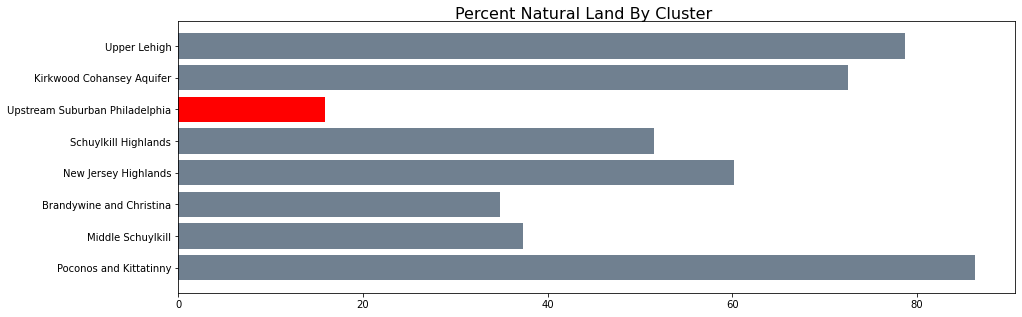

In [49]:
fig, ax = plt.subplots(1,1, figsize=(15,5))
fig.suptitle('Percent Natural Land By Cluster',fontsize=16,y=0.92)

colors = ['red' if i < 30 else 'slategrey' for i in clusterjoin_gdf['perc_natural']]
plt.barh(clusterjoin_gdf['name'], width=clusterjoin_gdf['perc_natural'], color=colors) 
plt.show()

### Focus area by cluster

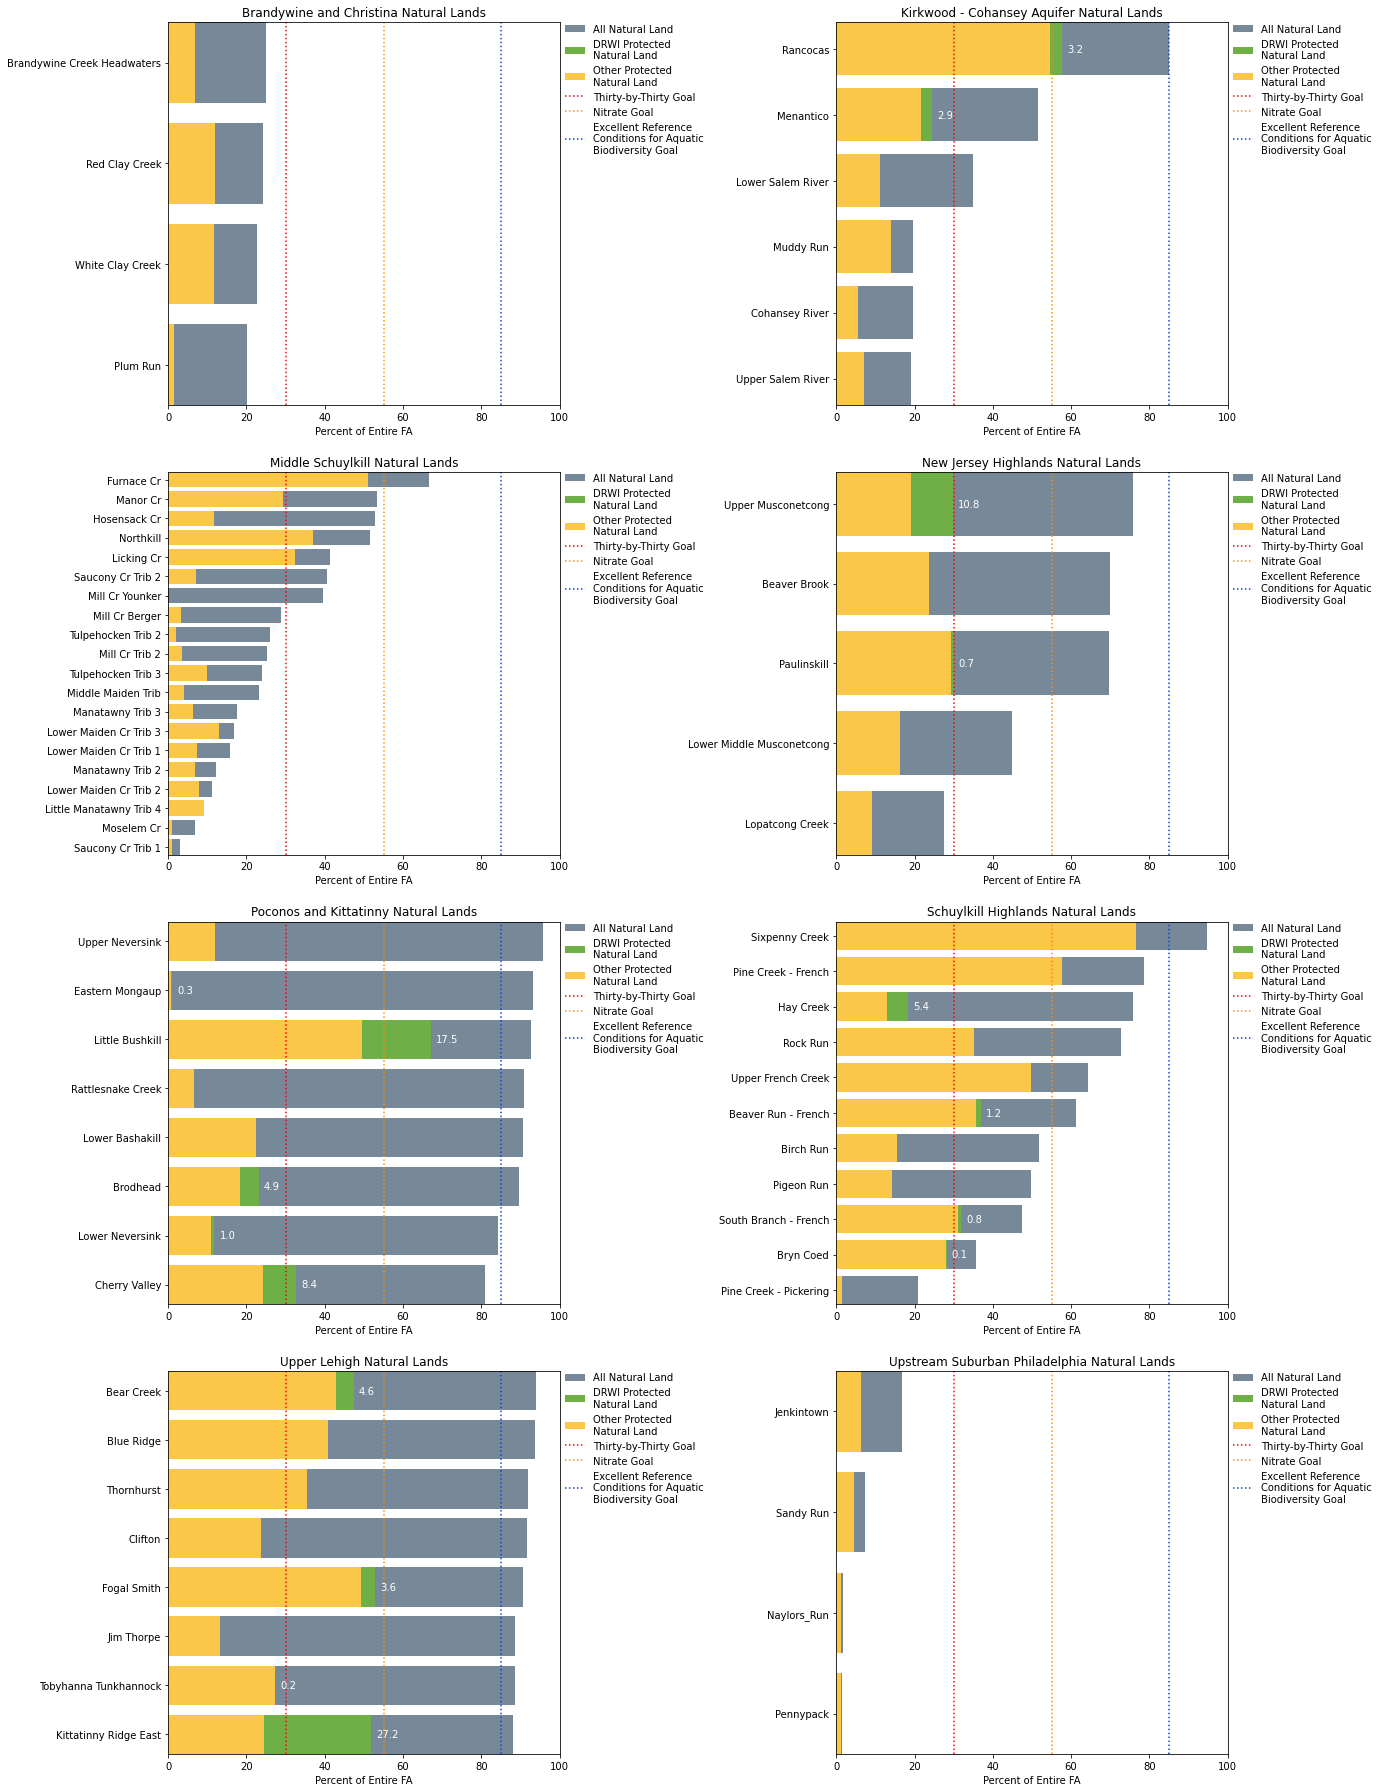

In [50]:
pa.plot_protected_land.plot_natural_cluster(fajoin_gdf,'upper right',(1.4, 1.02))

### Focus area by grouped by natural land %

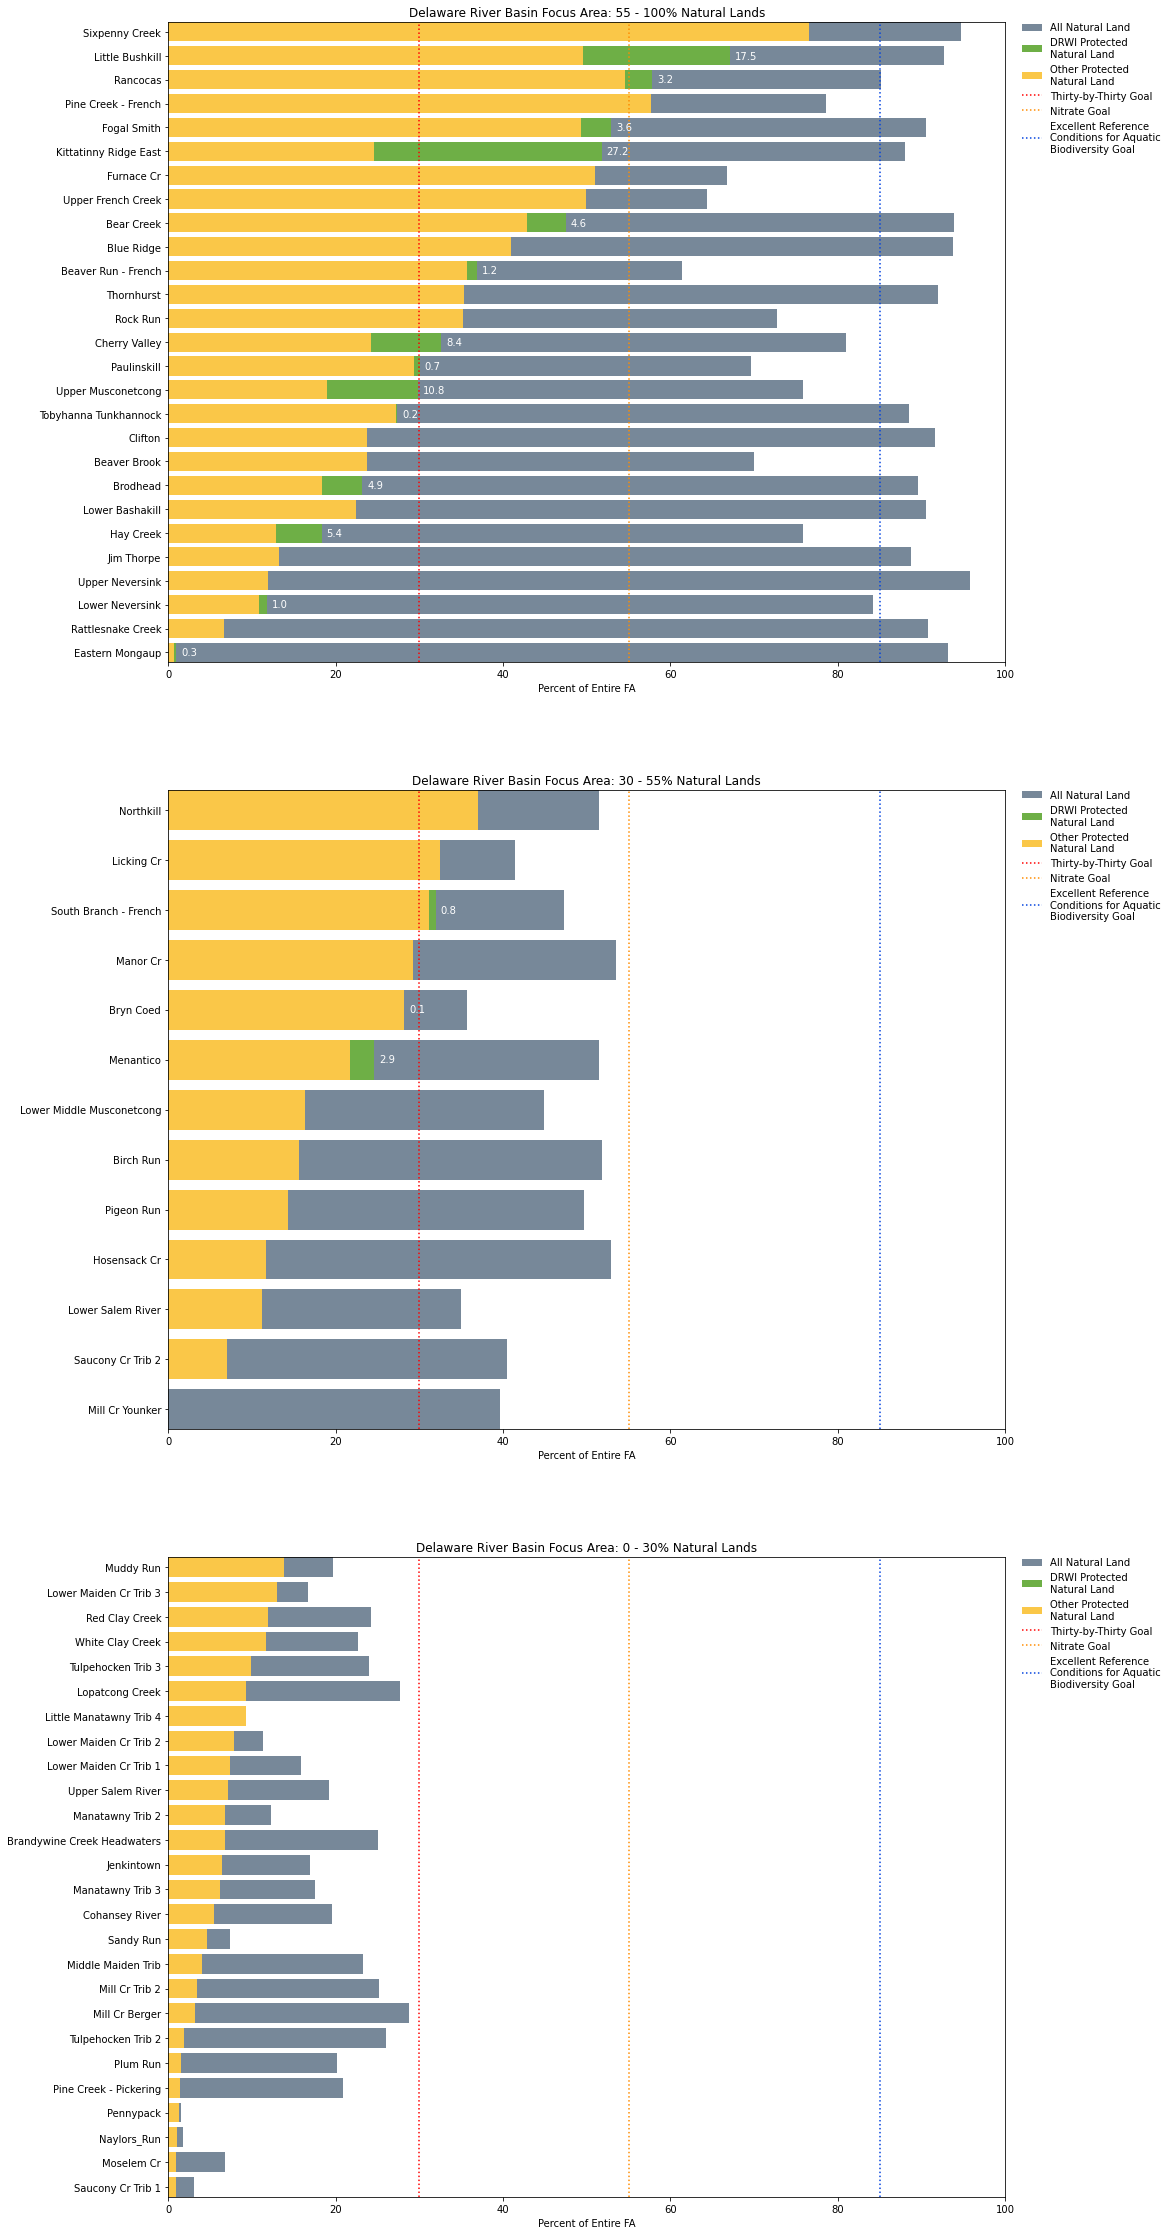

In [51]:
pa.plot_protected_land.plot_natural_level(fajoin_gdf, 'upper right', (1.1, 1.01))

## Maps

### Clusters

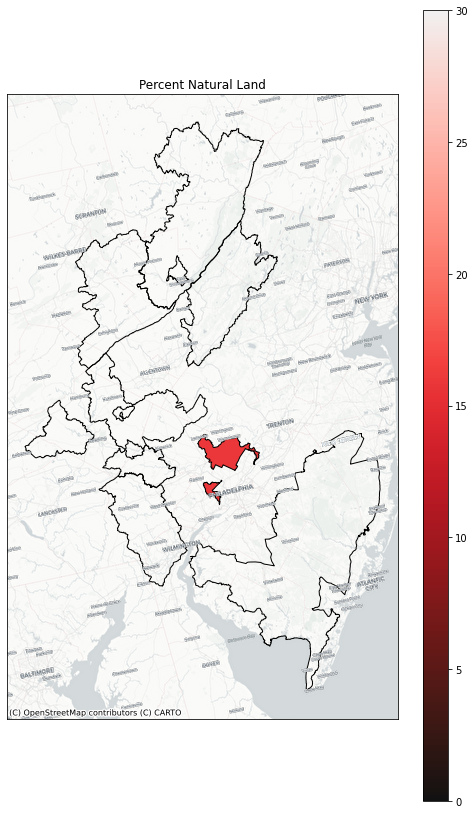

In [62]:
pa.plot.plot_3030_map(clusterjoin_gdf, 'natural', incl_boundary=True, boundary_gdf=clusterjoin_gdf)

### HUC

In [66]:
huc08_gdf = huc08_gdf.set_index('huc08')

In [67]:
huc12_in_drb_gdf = huc12join_gdf[huc12join_gdf.index.isin(hucs12_in_drb_list)]
huc08_in_drb_gdf = huc08_gdf[huc08_gdf.index.isin(hucs08_in_drb_list)]

In [68]:
huc08_in_drb_gdf = huc08_in_drb_gdf.drop('02040303', axis=0)

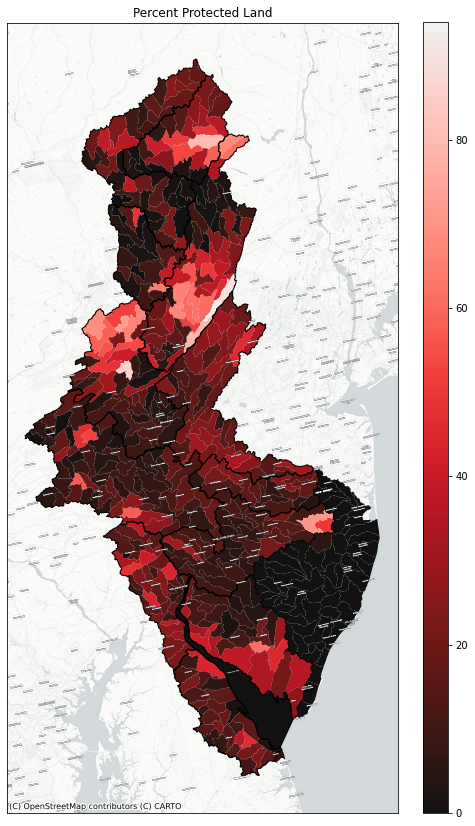

In [69]:
# Protected land
pa.plot.plot_3030_map(huc12_protec_gdf, nat_protect_type = 'protected', incl_boundary=True, boundary_gdf=huc08_in_drb_gdf)

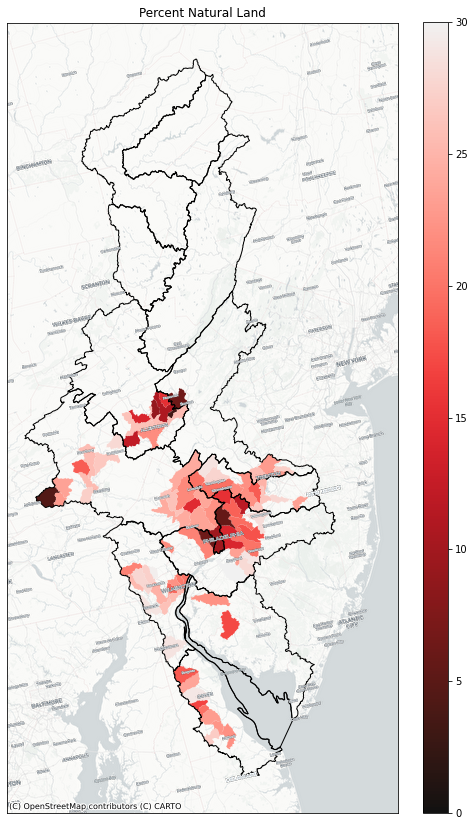

In [70]:
# Natural land
pa.plot.plot_3030_map(huc12_in_drb_gdf, nat_protect_type = 'natural', incl_boundary=True, boundary_gdf=huc08_in_drb_gdf)

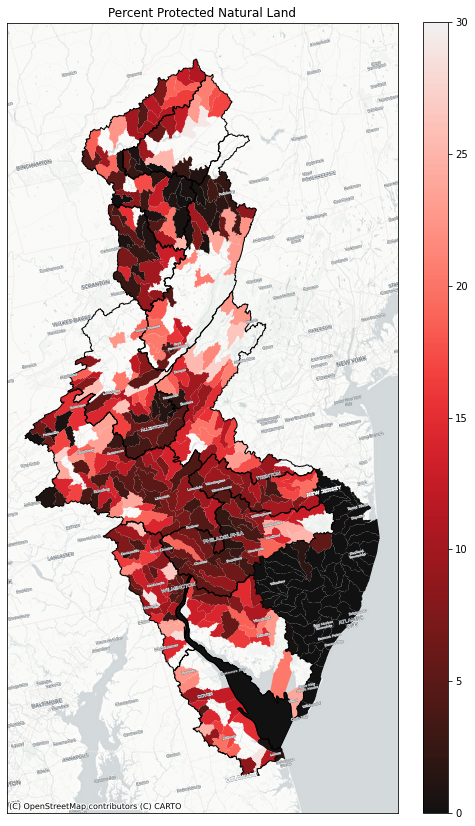

In [71]:
# Natural protected land
pa.plot.plot_3030_map(huc12_in_drb_gdf, nat_protect_type='naturalprotected', incl_boundary=True, boundary_gdf=huc08_in_drb_gdf)

# Summary of DRWI protection area
- Total FA
- FA protected
- DRWI FA protected
- FA natural
- FA natural protected
- DRWI FA natural protected

In [72]:
# Sq meters to acres conversion factor used in the following calculations
m2_ac_conv = 4046.86

## Total FA
Compute total area within all focus areas

In [73]:
# Total area (ac)
totalFA = fajoin_gdf.geometry.area.sum()/m2_ac_conv

print(f'Areage of all focus areas: {round(totalFA,2)}')

Areage of all focus areas: 682827.65


## FA Protected
Compute total *protected* area within all focus areas as well WCPA protected and DRWI protected

In [74]:
# Clip protected lands to all focus areas
fd_in_fa = fielddoc_gdf.clip(fajoin_gdf)
wcpa_in_fa = wcpa_gdf.clip(fajoin_gdf)

In [75]:
# Protected areas (ac)
fd_protec = fd_in_fa.geometry.area.sum()/m2_ac_conv
wcpa_protec = wcpa_in_fa.geometry.area.sum()/m2_ac_conv
all_protec = fd_protec + wcpa_protec

print(f'Acreage of all protected land within focus areas: {round(all_protec,2)} \nAcreage of all DRWI protected land within focus areas: {round(fd_protec,2)}')

Acreage of all protected land within focus areas: 236809.66 
Acreage of all DRWI protected land within focus areas: 16525.9


In [76]:
# Percent of all focus areas protected by all and DRWI
perc_fd_protec = round(fd_protec/totalFA*100,2)
perc_all_protec = round(all_protec/totalFA*100,2)
perc_fd_of_all = round(fd_protec/all_protec*100,2)

print(f'Percent of all focus area that is protected: {perc_all_protec} \nPercent of all focus area that is DRWI protected: {perc_fd_protec}')
print(f'Percent of *protected area* that is DRWI protected: {perc_fd_of_all}')

Percent of all focus area that is protected: 34.68 
Percent of all focus area that is DRWI protected: 2.42
Percent of *protected area* that is DRWI protected: 6.98


## FA Natural
Compute total *natural* land within all focus areas

In [77]:
# Natural land area (ac)
naturalFA = fajoin_gdf['natural_area_m2'].sum()/m2_ac_conv

print(f'Acreage of all natural land within focus areas: {round(naturalFA,2)}')

Acreage of all natural land within focus areas: 443396.6


In [78]:
# Percent of all focus area that is natural land
perc_nat = round(naturalFA/totalFA*100,2)

print(f'Percent of all focus area that is natural land: {perc_nat}')

Percent of all focus area that is natural land: 64.94


## FA Natural Protected
Compute the area of natural land that is also protected by all and by just DRWI

In [79]:
# ALl protected natural land within all focus areas (ac)
all_nat_protec = sum((fajoin_gdf.geometry.area*fajoin_gdf['all_protected_nat']/100)/m2_ac_conv)

print(f'Acreage of all natural and protected lands within focus areas: {round(all_nat_protec,2)}')

Acreage of all natural and protected lands within focus areas: 171060.62


In [80]:
# DRWI protected natural land within all focus areas (ac)
fd_nat_protec = sum((fajoin_gdf.geometry.area*fajoin_gdf['FieldDoc_PercNat']/100)/m2_ac_conv)

print(f'Acreage of all natural land that is DRWI protected within focus areas: {round(fd_nat_protec,2)}')

Acreage of all natural land that is DRWI protected within focus areas: 15633.41


In [81]:
# Percent of natural land protected
perc_nat_protec = round(all_nat_protec/naturalFA*100,2)
perc_fd_protec = round(fd_nat_protec/naturalFA*100,2)
perc_fd_nat_protec = round(fd_nat_protec/all_nat_protec*100, 2)

print(f'Percent of all natural area that is protected: {perc_nat_protec} \nPercent of all natural area that is DRWI protected: {perc_fd_protec}')
print(f'Percent of *protected natural area* that is DRWI protected: {perc_fd_nat_protec}')

Percent of all natural area that is protected: 38.58 
Percent of all natural area that is DRWI protected: 3.53
Percent of *protected natural area* that is DRWI protected: 9.14
